# Detecting Anomalies with Prophet and Mahalanobis Distance

This is the main code for detecting anomalies using the Mahalanobis Distance. The idea for this tool is:
1. Model individual pollutant levels using a "training period"
2. Forecast pollutant levels for the "testing period" (i.e. period when anomalies will be identified)
3. Compute residuals of both training and testing period
4. Use the distribution of residuals from the training period as a "baseline"
5. Compute distnace of testing period residuals to the above distribution using Mahalanobis distance
6. Any row with distance > threshold (3 is standard, 4 is very conservative) is considered an anomaly

The code can be adopted to use any forecast model (e.g. ARIMA or even machine learning models). One just has to modify the get_residuals function. We went with Prophet here because of speed.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from prophet import Prophet

def load_data(filepath, chunk=None):
    df = pd.read_csv(filepath, skipinitialspace=True)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    for col in df.columns:
        if col != "date":
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.sort_values(by='date').reset_index(drop=True)
    
    if chunk in ['week', 'month']:
        df = df.set_index('date')
        if chunk == 'week':
            df = df.resample('W').mean()
        elif chunk == 'month':
            df = df.resample('M').mean()
        df = df.reset_index()
    
    return df

# Prophet model to get residuals
def get_residuals(df, pollutant, train_start, train_end, predict_end):
    df = df.copy()
    df = df[['date', pollutant]]
    df = df.set_index('date').asfreq('D')
    df[pollutant] = df[pollutant].interpolate(limit_direction='both')  # fill in missing data linearly
    df = df.reset_index()

    model_df = df[(df['date'] >= train_start) & (df['date'] <= train_end)].copy()
    model_df.rename(columns={'date': 'ds', pollutant: 'y'}, inplace=True)

    # Default additive Prophet model
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive'
    )
    model.fit(model_df)

    # Forecast future dates
    full_range = pd.date_range(start=train_start, end=predict_end, freq='D')
    future = pd.DataFrame({'ds': full_range})

    forecast = model.predict(future)
    forecast = forecast[['ds', 'yhat']]
    forecast = forecast.rename(columns={'ds': 'date', 'yhat': f'{pollutant}_prediction'})

    return forecast

def mahalanobis_anomaly_detection(df, features, train_start, train_end, predict_end, threshold=3.0):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    
    residuals = pd.DataFrame({'date': pd.date_range(start=train_start, end=predict_end, freq='D')})

    # Loop through each pollutant to get residuals = actual - predicted
    for feature in features:
        pred_df = get_residuals(df, feature, train_start, train_end, predict_end)
        merged = pd.merge(df[['date', feature]], pred_df, on='date', how='right')
        residuals[feature] = merged[feature] - merged[f'{feature}_prediction']

    # Training and Testing Periods
    train_resid = residuals[(residuals['date'] >= train_start) & (residuals['date'] <= train_end)].dropna()
    test_resid = residuals[(residuals['date'] > train_end) & (residuals['date'] <= predict_end)].dropna()

    # Compute the mean and covariance of the training residuals
    mean_vec = train_resid[features].mean().values
    cov_mat = np.cov(train_resid[features].values, rowvar=False)
    inv_covmat = np.linalg.pinv(cov_mat)  # inverse covariance matrix

    # Calculate Mahalanobis distance for each row in the test set
    dists = []
    for _, row in test_resid.iterrows():
        x = row[features].values
        dist = mahalanobis(x, mean_vec, inv_covmat)
        dists.append(dist)

    # Add distances and label anomalies
    test_resid['mahalanobis'] = dists
    test_resid['anomaly'] = (test_resid['mahalanobis'] > threshold).astype(int)

    return test_resid

# This function just plots the Mahalanobis distances and highlights anomalies
def plot_mahalanobis(df, threshold=3.0):
    plt.figure(figsize=(14, 5))
    plt.plot(df['date'], df['mahalanobis'], label='Mahalanobis Distance')  # all distances
    plt.axhline(threshold, color='red', linestyle='--', label='Threshold')  # threshold line

    # Mark anomalies in red
    plt.scatter(
        df[df['anomaly'] == 1]['date'],
        df[df['anomaly'] == 1]['mahalanobis'],
        color='red',
        label='Anomaly'
    )

    plt.legend()
    plt.grid(True)
    plt.title("Multivariate Anomaly Detection using Prophet")
    plt.xlabel("Date")
    plt.ylabel("Distance")
    plt.show()

17:09:35 - cmdstanpy - INFO - Chain [1] start processing
17:09:36 - cmdstanpy - INFO - Chain [1] done processing
17:09:37 - cmdstanpy - INFO - Chain [1] start processing
17:09:37 - cmdstanpy - INFO - Chain [1] done processing
17:09:37 - cmdstanpy - INFO - Chain [1] start processing
17:09:38 - cmdstanpy - INFO - Chain [1] done processing


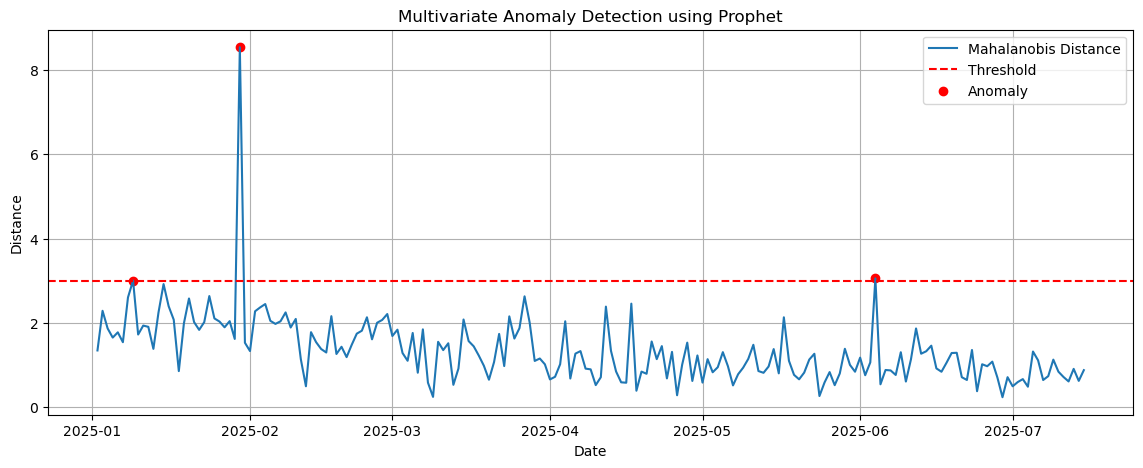

           date        pm25        no2        so2  mahalanobis
4026 2025-01-09 -112.810097  -5.179362 -10.826392     3.007375
4047 2025-01-30  358.898518   5.094142  -3.099064     8.540512
4172 2025-06-04  -31.269250  17.382937   2.485985     3.059393


In [8]:
# Choose a city (aqicn format)
city_df = load_data("aqicn_data/baotou.csv")

# Choose pollutants
pollutants = ['pm25', 'no2', 'so2']

# Training period
train_start = '2014-01-01'
train_end = '2025-01-01'

# Testing period
predict_end = '2026-01-01'

# Threshold
thresh = 3

anomalies_df = mahalanobis_anomaly_detection(
    city_df,
    features=pollutants,
    train_start=train_start,
    train_end=train_end,
    predict_end=predict_end,
    threshold=thresh
)

plot_mahalanobis(anomalies_df, threshold=thresh)

# Show detected anomalies (values are residuals)
print(anomalies_df[anomalies_df['anomaly'] == 1][['date'] + pollutants + ['mahalanobis']])